In [27]:
# %matplotlib inline
%matplotlib agg
%matplotlib agg
import networkx as nx
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import pickle as pkl
import sys
import os
import torch
import numpy as np
import torch_scatter
import torchgraphs as tg
import yaml
import pandas as pd
from rdkit import Chem
from pathlib import Path
from munch import munchify
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from IPython.display import display, HTML, SVG, Markdown,Image
import solubility.dataset
#from solubility.dataset import SolubilityDataset, smiles_to_graph
#from solubility.networks import SolubilityGN
from polymer_unit.dataset import SolubilityDataset, smiles_to_graph,get_pu_dist
from polymer_unit.networks import SolubilityGN
from utils import import_
from PURS import get_pu,get_bratch_dist2,update_bratch,get_pu_dict
import relevance

In [ ]:
label='uh-c'
data_path='../data/polymer_test.csv'
model_path='../models/polymer-unit/uh/layers3_lr.01_biasyes_size256_wd.0001_dryes_e75_mean_BAUEZF'
picture_path='data/polymer/'#在此路径下放置需要分析的csv数据，格式同输入数据一样

In [28]:
def label_bin(label):
    return '$+$' if bool(label>0) else '$-$'

def label_cat(label):
        return '$+$' if bool(label>0) else '$\cdot$'

In [29]:
def mol_to_networkx(m):
    g = nx.Graph()
    for a in m.GetAtoms():
        g.add_node(a.GetIdx(), symbol=a.GetSymbol())
    for b in m.GetBonds():
        g.add_edge(b.GetBeginAtomIdx(), b.GetEndAtomIdx(), bond=str(b.GetBondType()))
    return g

def autocrop(im, bgcolor='white'):
    if im.mode != "RGB":
        im = im.convert("RGB")
    bg = Image.new("RGB", im.size, bgcolor)
    diff = ImageChops.difference(im, bg)
    bbox = diff.getbbox()
    if bbox:
        return im.crop(bbox)
    return None # no contents

In [30]:
#from PIL import Image, ImageChops
from PIL import ImageChops
from io import BytesIO

from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions

def moltosvg(mol,node_colors={}, edge_colors={}, molSize=(450,150),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DSVG(molSize[0],molSize[1])
    drawer.drawOptions().useBWAtomPalette()
    drawer.drawOptions().padding = .1
    drawer.DrawMolecule(
        mc,
        highlightAtoms=[i for i in range(len(node_colors))], 
        highlightAtomColors={i: tuple(c) for i, c in enumerate(node_colors)}, 
        highlightBonds=[i for i in range(len(edge_colors))],
        highlightBondColors={i: tuple(c) for i, c in enumerate(edge_colors)},
        highlightAtomRadii={i: .5 for i in range(len(node_colors))}
    )
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    # It seems that the svg renderer used doesn't quite hit the spec.
    # Here are some fixes to make it work in the notebook, although I think
    # the underlying issue needs to be resolved at the generation step
    # svg = svg.replace('svg:','')
    return svg

In [31]:
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions

def moltopng(path,name,mol,node_colors, edge_colors, molSize=(900,300),kekulize=True):
    mc = Chem.Mol(mol.ToBinary())
    if kekulize:
        try:
            Chem.Kekulize(mc)
        except:
            mc = Chem.Mol(mol.ToBinary())
    if not mc.GetNumConformers():
        rdDepictor.Compute2DCoords(mc)
    drawer = rdMolDraw2D.MolDraw2DCairo(molSize[0],molSize[1])
    drawer.drawOptions().useBWAtomPalette()
    #修改字体大小
    drawer.drawOptions().maxFontSize=60
    drawer.drawOptions().minFontSize=30
    #drawer.drawOptions().padding = .2
    drawer.DrawMolecule(
        mc,
        highlightAtoms=[i for i in range(len(node_colors))], 
        highlightAtomColors={i: tuple(c) for i, c in enumerate(node_colors)}, 
        highlightBonds=[i for i in range(len(edge_colors))],
        highlightBondColors={i: tuple(c) for i, c in enumerate(edge_colors)},
        highlightAtomRadii={i: 1.2 for i in range(len(node_colors))}
    )
    drawer.FinishDrawing()
    drawer.WriteDrawingText(path+'{}.png'.format(name))
    
    #return drawer.GetDrawingText()


In [6]:
ds = SolubilityDataset(data_path)
display(ds.df.sort_values(label).head())
display(ds.df.sort_values(label).tail())

C:\Users\20599\ANACONDA-FILE\deep_learning\gn-exp\gne\src\PURS.py:1396: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:766.)
  nozero=torch.nonzero(i)


Compound ID                                             smiles   uh     ue  \
0        2-p24  CC1=C(F)C2=C(/C(C(N2CCCC(CCCCCCCCCCCCCCCCCC)CC...  0.0  14.90   
30       5-p4b  CC1=CC2=C3C(C4=CC(C5=CC=C(C6=C(F)C(F)=C(C)C7=N...  0.0   3.50   
29       PNDI9  O=C(N(CC(CCCCCCCCCCCC)CCCCCCCCCC)C1=O)C2=C(C3=...  0.0   3.50   
27       2-p82  O=C(N1CC(CCCCCCCCCC)CCCCCCCC)C2C(SC(C)=C2)C3C(...  0.0   3.71   
26       PBTI1  CC1=CC(C(N2CC(CCCCCCCCCC)CCCCCCCC)=O)=C(S1)C(S...  0.0   3.71   

    uh-c  ue-c     HOMO     LUMO  
0      0     3 -0.19696 -0.01045  
30     0     3 -0.21016 -0.02888  
29     0     3 -0.19966 -0.03027  
27     0     3 -0.21516  0.04601  
26     0     3 -0.21516  0.04601

Compound ID                                             smiles    uh    ue  \
6        3-p62  CC1=CC=C(C2=C3C(C(N2CC(CCCCCCCC)CCCCCCCCCC)=O)...  8.90  7.71   
22  PDPP2TzBDT  CC1=CN=C(C(N(CC(CCCCCCCCCCCC)CCCCCCCCCC)C2=O)=...  5.47  5.33   
10     3-p65-2  O=C(N(CCCC(CCCCCCCCCC)CCCCCCCCCC)C1=C/2C=CC(C3...  6.41  6.76   
4        3-p71  CC1=NC=C(C2=CN=C(C3=CC(CC(CCCCCCCCCCCC)CCCCCCC...  6.87  8.49   
24        p40b  O=C1C(C2=C(C3=CC=C(C)S3)N1CCCCC[Si](C)(O[Si](C...  8.84  4.34   

    uh-c  ue-c     HOMO     LUMO  
6      3     3 -0.17297 -0.02642  
22     3     3 -0.18214  0.00361  
10     3     3 -0.18843  0.01675  
4      3     3 -0.18090 -0.00600  
24     3     3 -0.17869  0.02407

In [8]:
mols = [Chem.MolFromSmiles(s) for s in ds.df.sort_values(label, ascending=False).head(8).smiles]
names = ds.df.sort_values(label, ascending=False).head(8)['Compound ID']
svg = Draw.MolsToGridImage(mols, molsPerRow=2, useSVG=True, subImgSize=(400, 200), legends=list(names))
svg

In [9]:
mols = [Chem.MolFromSmiles(s) for s in ds.df.sort_values(label, ascending=True).head(8).smiles]
names = ds.df.sort_values(label, ascending=True).head(8)['Compound ID']
svg = Draw.MolsToGridImage(mols, molsPerRow=2, useSVG=True, subImgSize=(400, 200), legends=list(names))
svg

In [10]:
experiment = Path(model_path) 

with experiment.joinpath('experiment.latest.yaml').open('r') as f:
    model = munchify(yaml.safe_load(f)['model'])
model.state_dict = experiment / 'model.latest.pt'

if 'aggregation' not in model.kwargs:
    model.kwargs['aggregation'] = 'mean'

net = SolubilityGN(*model.args, **model.kwargs)
net.load_state_dict(torch.load(model.state_dict, map_location='cpu'))
net.eval();

In [11]:
class SolubilityRelevance(SolubilityGN):
    def __init__(self, num_layers, hidden_bias, hidden_node, dropout, aggregation):
        super(SolubilityGN, self).__init__()

        hidden_edge = hidden_node // 4
        hidden_global = hidden_node // 8
        
        self.encoder = torch.nn.Sequential(OrderedDict({
            'edge': relevance.EdgeLinearRelevance(hidden_edge, edge_features=8),
            'edge_relu': relevance.EdgeReLURelevance(),
            'node': relevance.NodeLinearRelevance(hidden_node, node_features=167),
            'node_relu': relevance.NodeReLURelevance(),
            'global': relevance.GlobalLinearRelevance(hidden_global, node_features=hidden_node,
                                      edge_features=hidden_edge, aggregation=aggregation),
            'global_relu': relevance.GlobalReLURelevance(),
        }))
        if dropout:
            self.hidden = torch.nn.Sequential(OrderedDict({
                f'hidden_{i}': torch.nn.Sequential(OrderedDict({
                    'edge': relevance.EdgeLinearRelevance(hidden_edge, edge_features=hidden_edge,
                                          sender_features=hidden_node, bias=hidden_bias),
                    'edge_relu': relevance.EdgeReLURelevance(),
                    'edge_dropout': tg.EdgeDropout(),
                    'node': relevance.NodeLinearRelevance(hidden_node, node_features=hidden_node, incoming_features=hidden_edge,
                                          aggregation=aggregation, bias=hidden_bias),
                    'node_relu': relevance.NodeReLURelevance(),
                    'node_dropout': tg.EdgeDropout(),
                    'global': relevance.GlobalLinearRelevance(hidden_global, node_features=hidden_node, edge_features=hidden_edge,
                                              global_features=hidden_global, aggregation=aggregation, bias=hidden_bias),
                    'global_relu': relevance.GlobalReLURelevance(),
                    'global_dropout': tg.EdgeDropout(),
                }))
                for i in range(num_layers)
            }))
        else:
            self.hidden = torch.nn.Sequential(OrderedDict({
                f'hidden_{i}': torch.nn.Sequential(OrderedDict({
                    'edge': relevance.EdgeLinearRelevance(hidden_edge, edge_features=hidden_edge,
                                          sender_features=hidden_node, bias=hidden_bias),
                    'edge_relu': relevance.EdgeReLURelevance(),
                    'node': relevance.NodeLinearRelevance(hidden_node, node_features=hidden_node, incoming_features=hidden_edge,
                                          aggregation=aggregation, bias=hidden_bias),
                    'node_relu': relevance.NodeReLURelevance(),
                    'global': relevance.GlobalLinearRelevance(hidden_global, node_features=hidden_node, edge_features=hidden_edge,
                                              global_features=hidden_global, aggregation=aggregation, bias=hidden_bias),
                    'global_relu': relevance.GlobalReLURelevance(),
                }))
                for i in range(num_layers)
            }))
        self.readout_globals = relevance.GlobalLinearRelevance(4, global_features=hidden_global, bias=True)

net_rel = SolubilityRelevance(*model.args, **model.kwargs)
net_rel.load_state_dict(torch.load(model.state_dict, map_location='cpu'))
net_rel.eval();

In [12]:
batch, _ = tg.GraphBatch.collate(list(ds))

solubility_out = net(batch).global_features.squeeze()

In [13]:
pred = torch.tensor(solubility_out.detach().numpy())
pred = torch.argmax(pred,1,keepdim=True).squeeze()

In [14]:
solubility_out = pd.Series(pred.numpy(), name='MyPrediction', index=ds.df.index)

In [15]:
df_out = pd.merge(solubility_out, ds.df, left_index=True, right_index=True, sort=False)
df_out['mse_loss'] = (df_out[label] - df_out.MyPrediction) ** 2

display(df_out.sort_values('mse_loss').head())
display(df_out.sort_values('mse_loss').tail())

print(df_out.mse_loss.mean())

MyPrediction Compound ID  \
0              0       2-p24   
31             1      10-p85   
30             0       5-p4b   
29             0       PNDI9   
27             0       2-p82   

                                               smiles   uh     ue  uh-c  ue-c  \
0   CC1=C(F)C2=C(/C(C(N2CCCC(CCCCCCCCCCCCCCCCCC)CC...  0.0  14.90     0     3   
31  CC1=CC=C(C2=C3C(C(N2CCCCCCC(CCCCCCCCCC)CCCCCCC...  0.1   3.47     1     3   
30  CC1=CC2=C3C(C4=CC(C5=CC=C(C6=C(F)C(F)=C(C)C7=N...  0.0   3.50     0     3   
29  O=C(N(CC(CCCCCCCCCCCC)CCCCCCCCCC)C1=O)C2=C(C3=...  0.0   3.50     0     3   
27  O=C(N1CC(CCCCCCCCCC)CCCCCCCC)C2C(SC(C)=C2)C3C(...  0.0   3.71     0     3   

       HOMO     LUMO  mse_loss  
0  -0.19696 -0.01045         0  
31 -0.17327  0.00547         0  
30 -0.21016 -0.02888         0  
29 -0.19966 -0.03027         0  
27 -0.21516  0.04601         0

MyPrediction Compound ID  \
2              0       PNDI8   
10             1     3-p65-2   
32             0       5-p15   
15             0         p43   
22             0  PDPP2TzBDT   

                                               smiles    uh    ue  uh-c  ue-c  \
2   O=C(N(CC(CCCCCCCCCCCC)CCCCCCCCCC)C1=O)C2=C(C3=...  1.70  8.50     2     3   
10  O=C(N(CCCC(CCCCCCCCCC)CCCCCCCCCC)C1=C/2C=CC(C3...  6.41  6.76     3     3   
32  CC1=CN=C(C2=C3C(C(N2CC(CCCCCCCCCC)CCCCCCCC)=O)...  2.04  3.36     2     3   
15  O=C1C(C2=C(C3=NC=C(C)C=C3)N1CC(CCCCCCCCCC)CCCC...  2.78  6.30     2     3   
22  CC1=CN=C(C(N(CC(CCCCCCCCCCCC)CCCCCCCCCC)C2=O)=...  5.47  5.33     3     3   

       HOMO     LUMO  mse_loss  
2  -0.19840 -0.03150         4  
10 -0.18843  0.01675         4  
32 -0.18106  0.00490         4  
15 -0.18785 -0.00649         4  
22 -0.18214  0.00361         9

1.0


In [16]:
from IPython.display import Image
import csv

In [17]:
def process_smiles(file_name):
    
    file=open(file_name)
    fileReader=csv.reader(file)
    filedata=list(fileReader)

    smi_list=[]
    name_list0=[]#重名未做处理的名称列表
    name_list=[]#做了重名处理的名称列表
    mol_list = []
    num_list = []
    label_list1 = []
    label_list2 = []
    for i in filedata:
        #Rdkit识别不出顺反，要把'/'与'\'去掉
        if '/'in i[1]:
            i[1]=i[1].replace('/','')
        if '\\'in i[1]:
            i[1]=i[1].replace('\\','')
        mol=Chem.MolFromSmiles(i[1])
        if mol:
            smi=Chem.MolToSmiles(mol)
            num = mol.GetNumAtoms()
            num_list.append(num)
            smi_list.append(smi)
            AllChem.EmbedMolecule(mol)
            mol_list.append(mol)
            adj = Chem.GetAdjacencyMatrix(mol)
            label_list1.append(i[2])
            label_list2.append(i[3])
        
        #重名的数据会在后面加上重复的个数
            if i[0] in name_list0:
                num = name_list.count(i[0])
                name = i[0]+'-'+str(num)
                name_list.append(name)
            else:
                name_list.append(i[0])
            name_list0.append(i[0])
            
    return smi_list,name_list0,name_list,mol_list,num_list,label_list1,label_list2

In [ ]:
smi_list,name_list0,name_list,mol_list,num_list,label_list1,label_list2 = process_smiles(data_path)
total_bratch_dist = get_bratch_dist2(smi_list,name_list)
ring_total_list0,total_neighbor_data0,total_inner_dist0,_=get_pu(smi_list,name_list)
total_neighbor_data,total_inner_dist,ring_total_list = update_bratch(name_list,smi_list,total_neighbor_data0,total_inner_dist0,total_bratch_dist)
total_neighbor_data,total_inner_dist,ring_total_list = get_new_neighbor_data(total_neighbor_data,total_inner_dist,name_list,smi_list)

In [32]:
def get_analysis_picture(path,filename,s):
    #filename填入需要分析的结构文件名
    #s是纯文件名，比如“data/polymer.csv”填写“polymer_”,填写文件名方便归纳整理图片
    smi_list,name_list0,name_list,mol_list,num_list,label_list1,label_list2= process_smiles(filename)
    name_list2 = []
    for idx,i in enumerate(name_list):
        uh = label_list1[idx]
        ue = label_list2[idx]
        name = 'name_'+ str(i)+'_'+'uh_'+str(uh)+'_'+'ue_'+str(ue)
        name_list2.append(name)
    total_bratch_dist = get_bratch_dist2(smi_list,name_list)
    ring_total_list0,total_neighbor_data0,total_inner_dist0,_=get_pu(smi_list,name_list)
    total_neighbor_data,total_inner_dist,ring_total_list = update_bratch(name_list,smi_list,total_neighbor_data0,total_inner_dist0,total_bratch_dist)
    total_neighbor_data,total_inner_dist,ring_total_list = get_new_neighbor_data(total_neighbor_data,total_inner_dist,name_list,smi_list)
    inner_dist={}
    for key,values in total_inner_dist.items():
        inner_list = []
        for k,v in values.items():
            inner_list.append(v)
        inner_dist[key]=inner_list
    pu_dist = get_pu_dist(filename)
    
    for idx,sm in enumerate(smi_list):    
        name = name_list[idx]
        solubility_target = np.nan
        mol = Chem.MolFromSmiles(sm)
        graph_in = smiles_to_graph(pu_dist,name)
        batch = tg.GraphBatch.from_graphs([graph_in]).requires_grad_().zero_grad_()
        out = net_rel(batch).global_features
        #display(Markdown(f'### {name}'))
        #display(Markdown(f'{np.round(solubility_target, 2)}\t{round(out.item(), 2)}'))
        out.backward(out)
        node_rel = batch.node_features.grad.sum(dim=1)
        atom_rel = torch.zeros([mol.GetNumAtoms(),1])
        inner = inner_dist[name]
        for Idx,I in enumerate(inner):
            rel = node_rel[Idx]
            for j in I:
                atom_rel[j]=rel
        atom_rel = atom_rel.view([1,mol.GetNumAtoms()])
        atom_rel = atom_rel[0]
        vmax = max(atom_rel.abs().max(), 1e-16)
        vmin = -vmax
        file_name = s+name_list2[idx]
        #clist=['cyan','mediumturquoise','paleturquoise','lightcyan','azure','aliceblue','whitesmoke','lavenderblush','mistyrose','peachpuff','lightsalmon','salmon','tomato']
        clist=['cyan','mediumturquoise','paleturquoise','lightcyan','whitesmoke','peachpuff','lightsalmon','salmon','tomato']
        newcmp = LinearSegmentedColormap.from_list('chaos',clist)
        node_colors = newcmp((atom_rel - vmin) / (vmax - vmin) )[:,:3]
        #node_colors = cm.get_cmap('coolwarm')((atom_rel - vmin) / (vmax - vmin) )[:,:3]
        node_colors[0]=node_colors[1]
        moltopng(path,file_name,mol, node_colors=node_colors, edge_colors={}, molSize=(900,900))
        display(Image(filename = path+'{}.png'.format(file_name), width=1000))


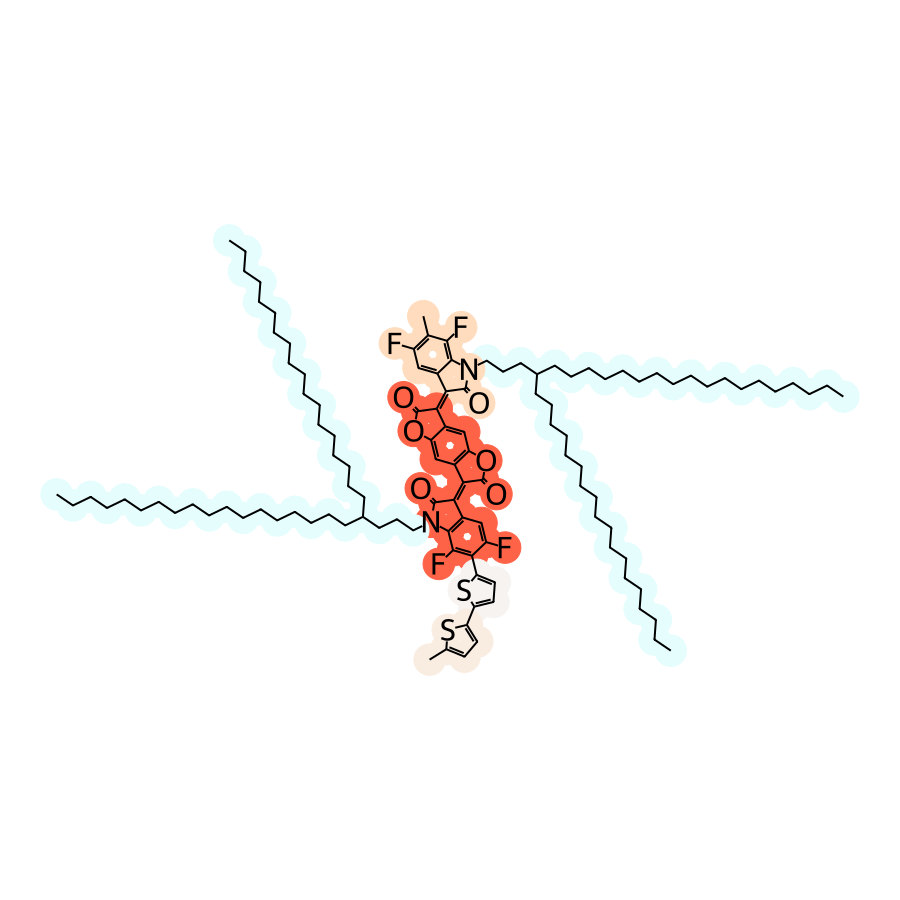

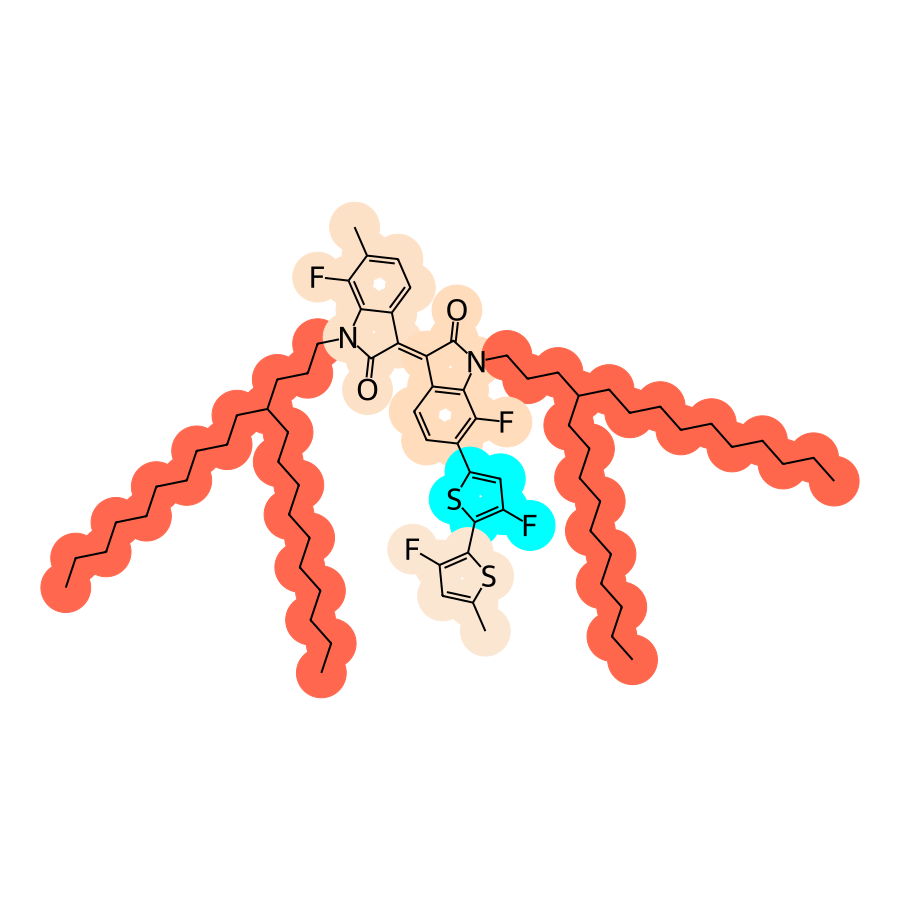

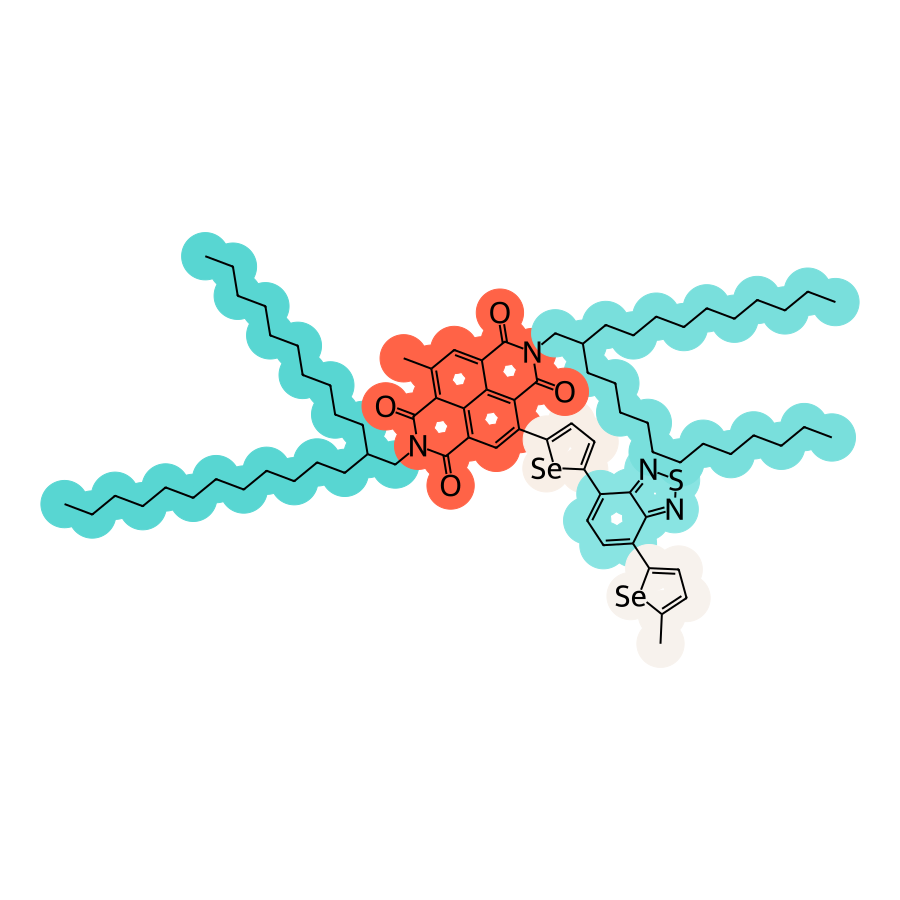

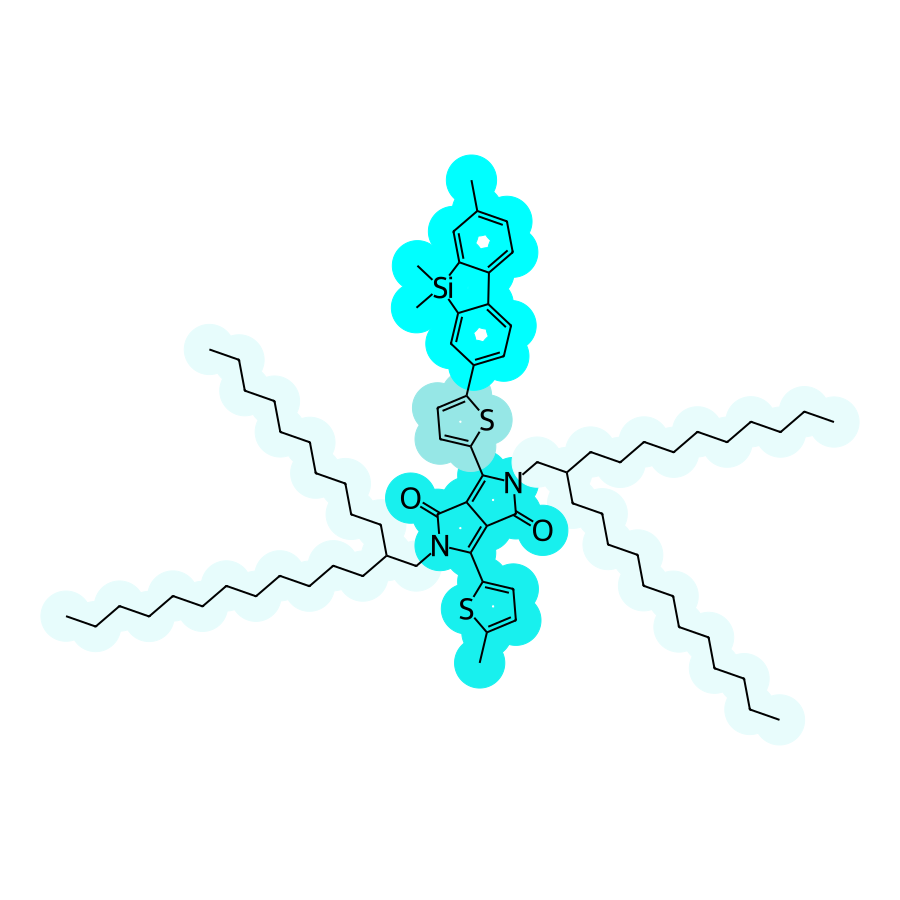

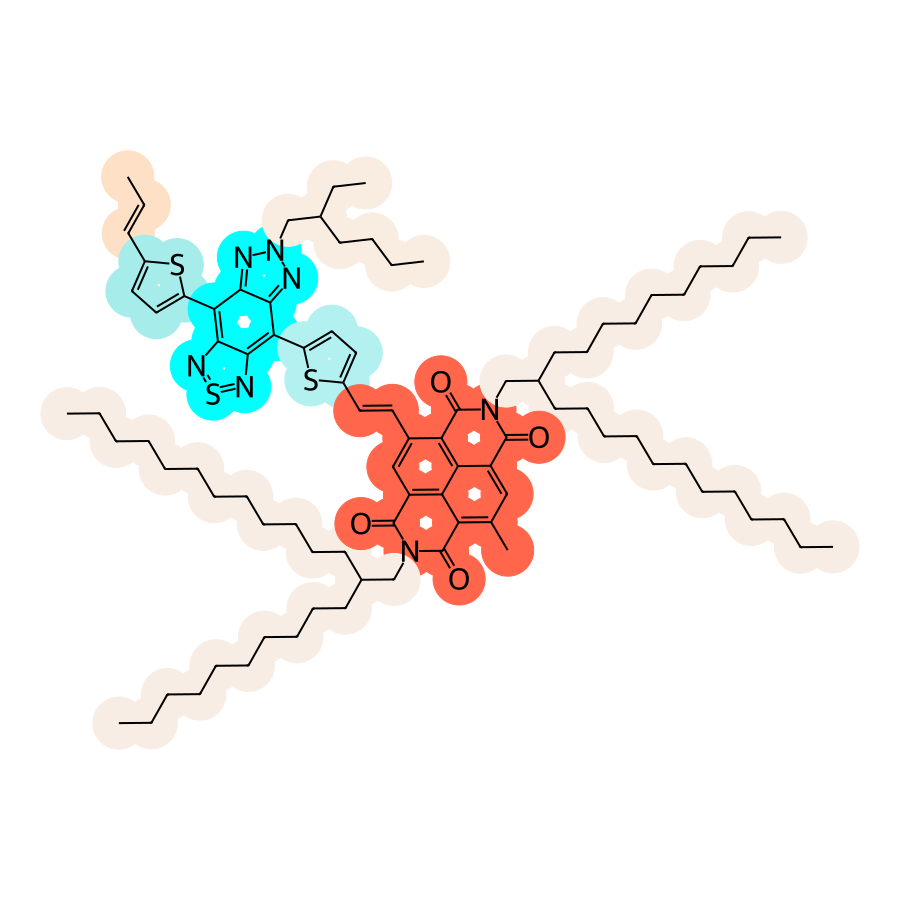

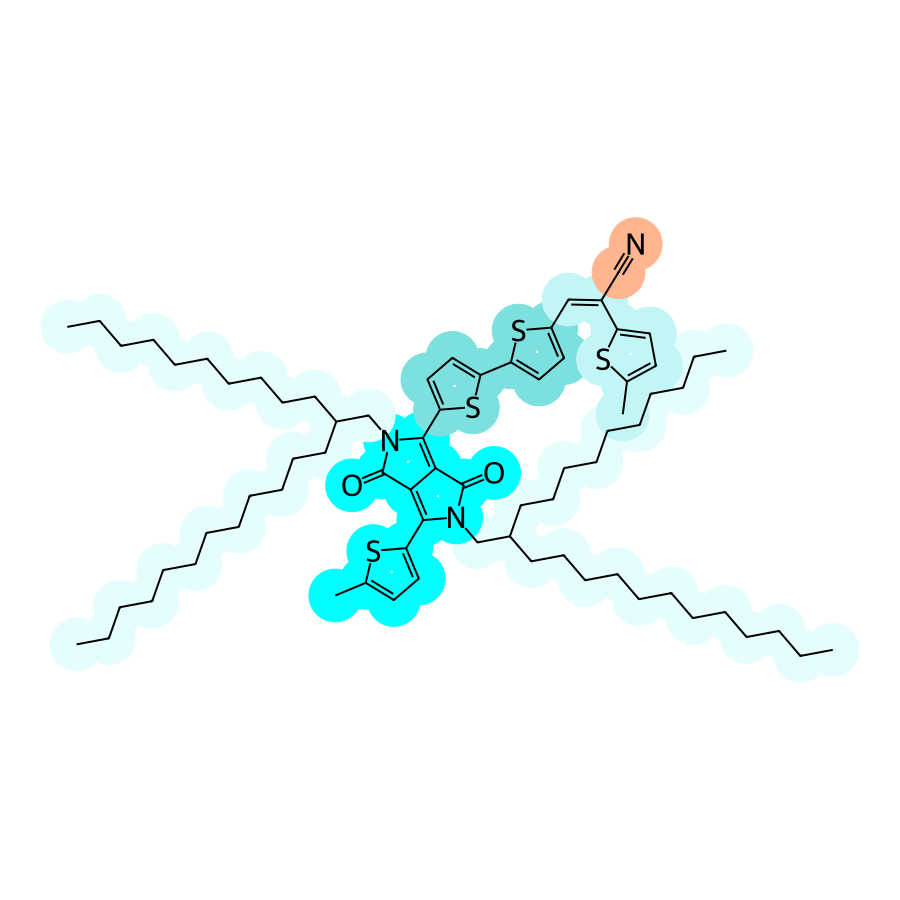

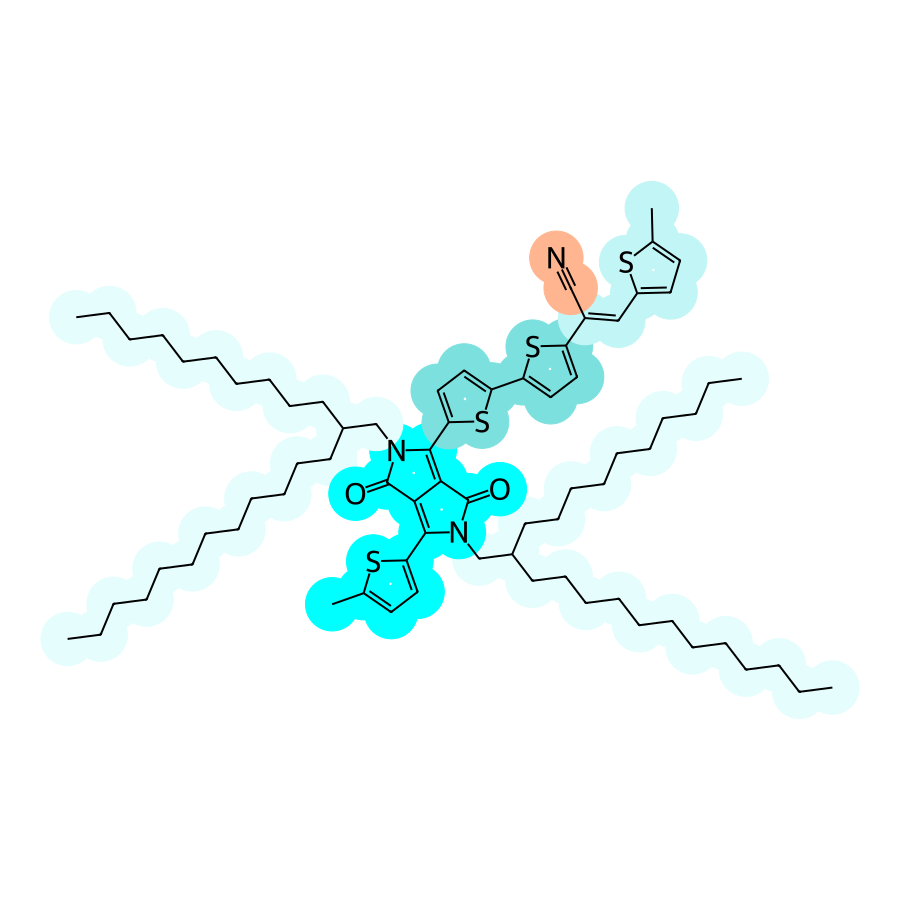

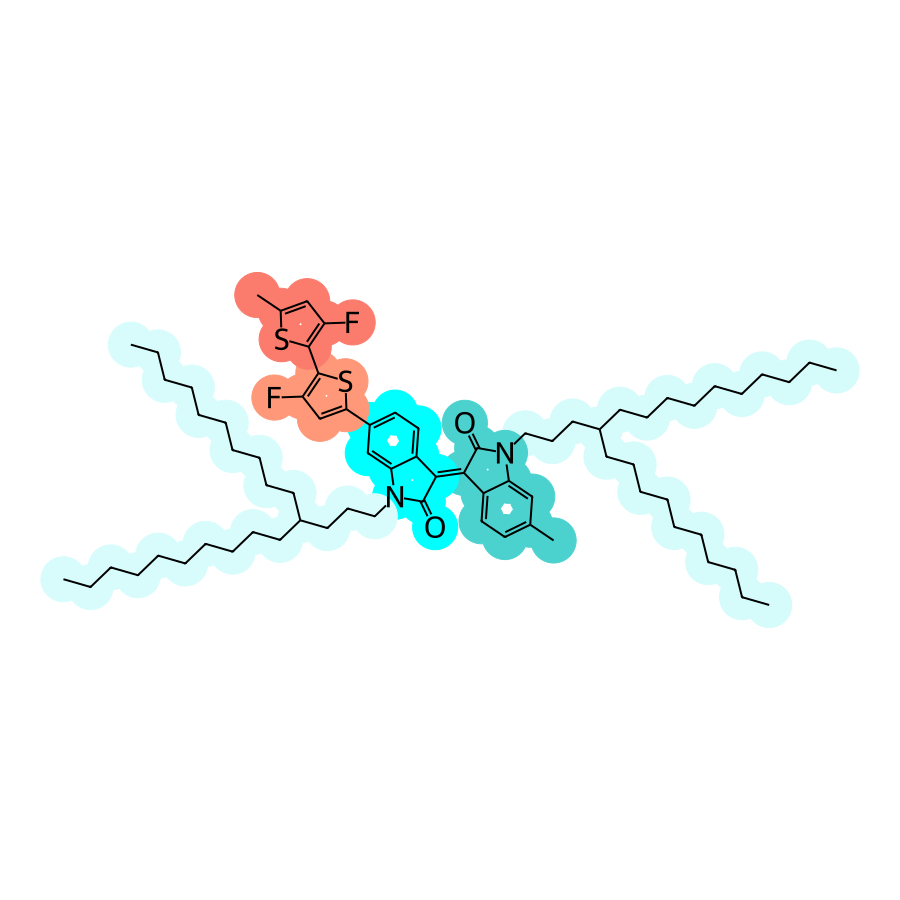

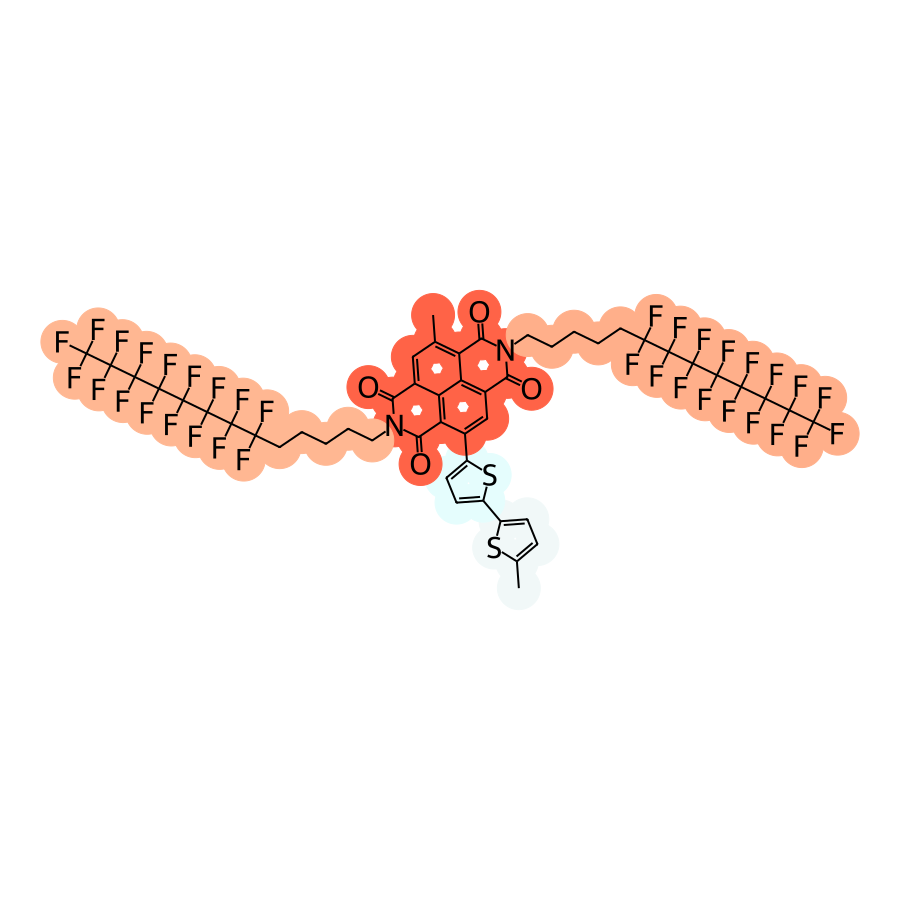

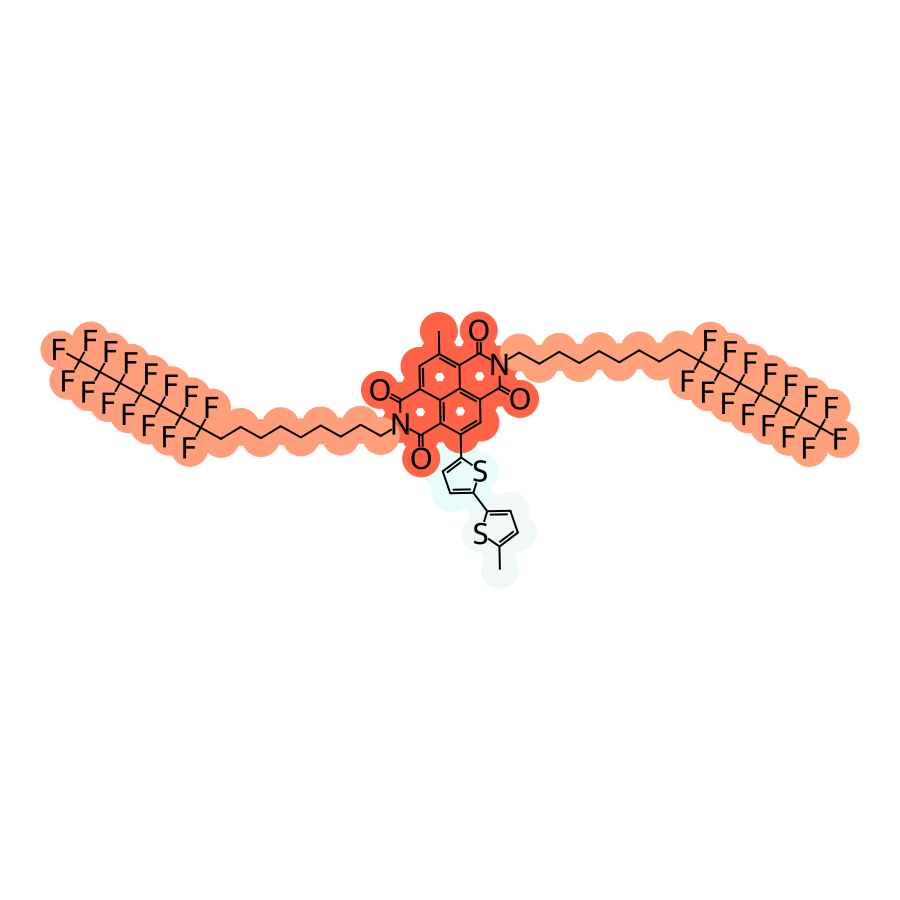

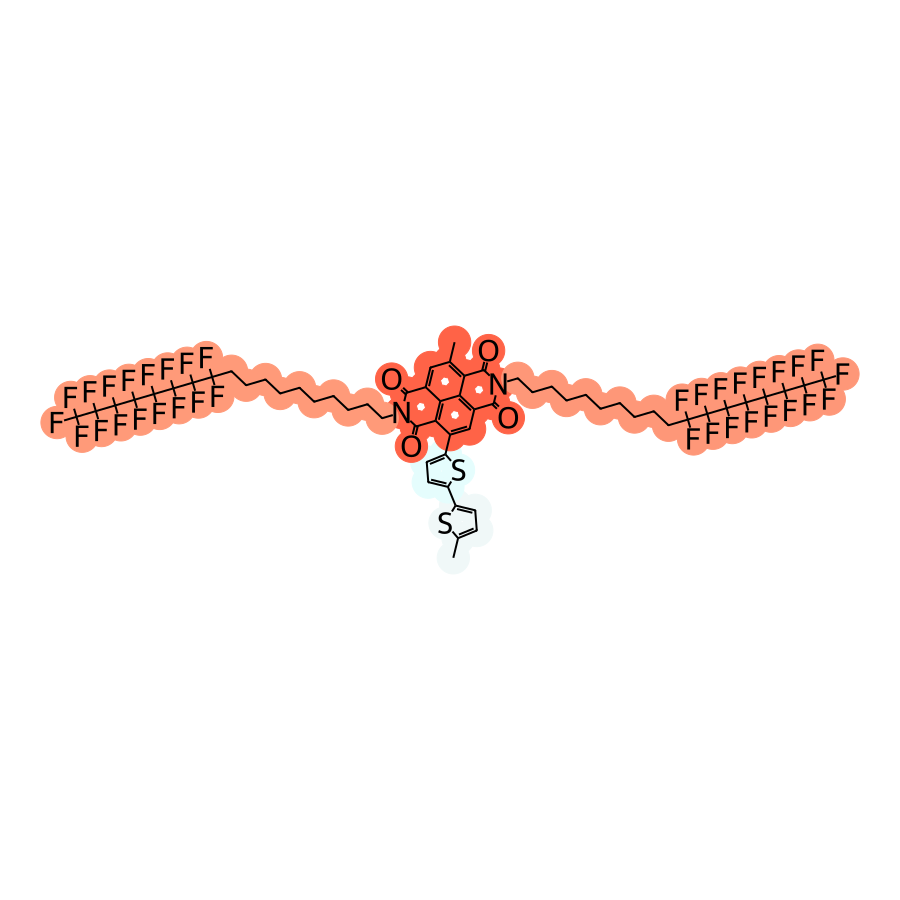

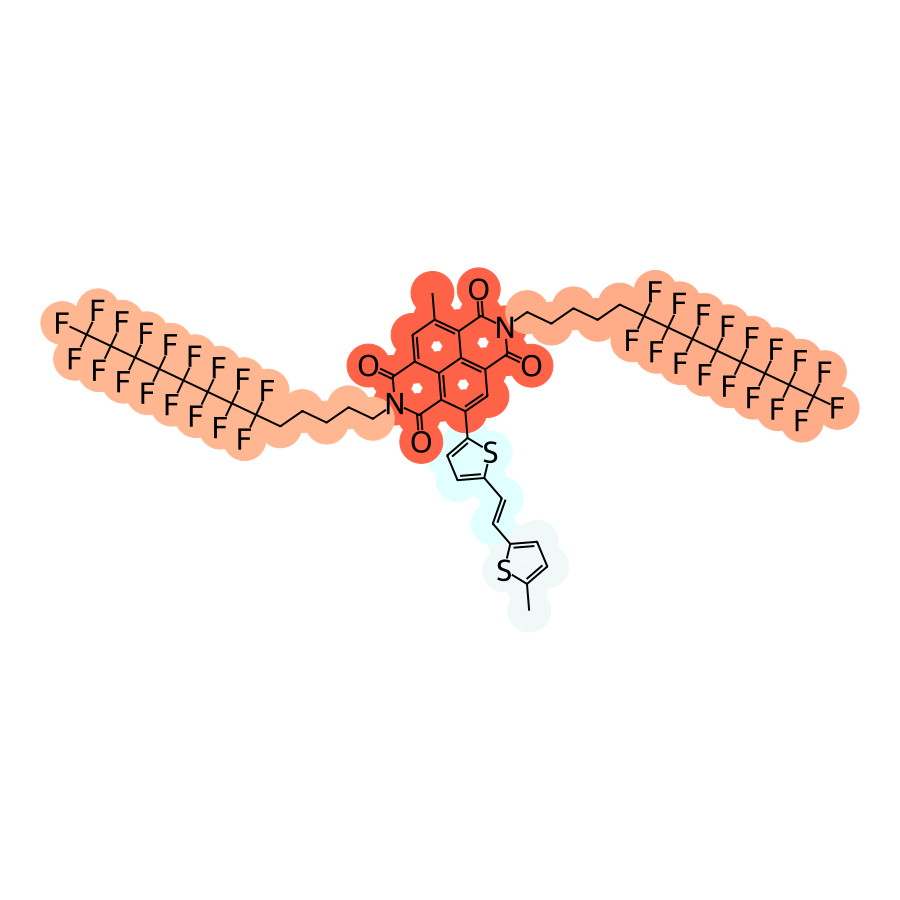

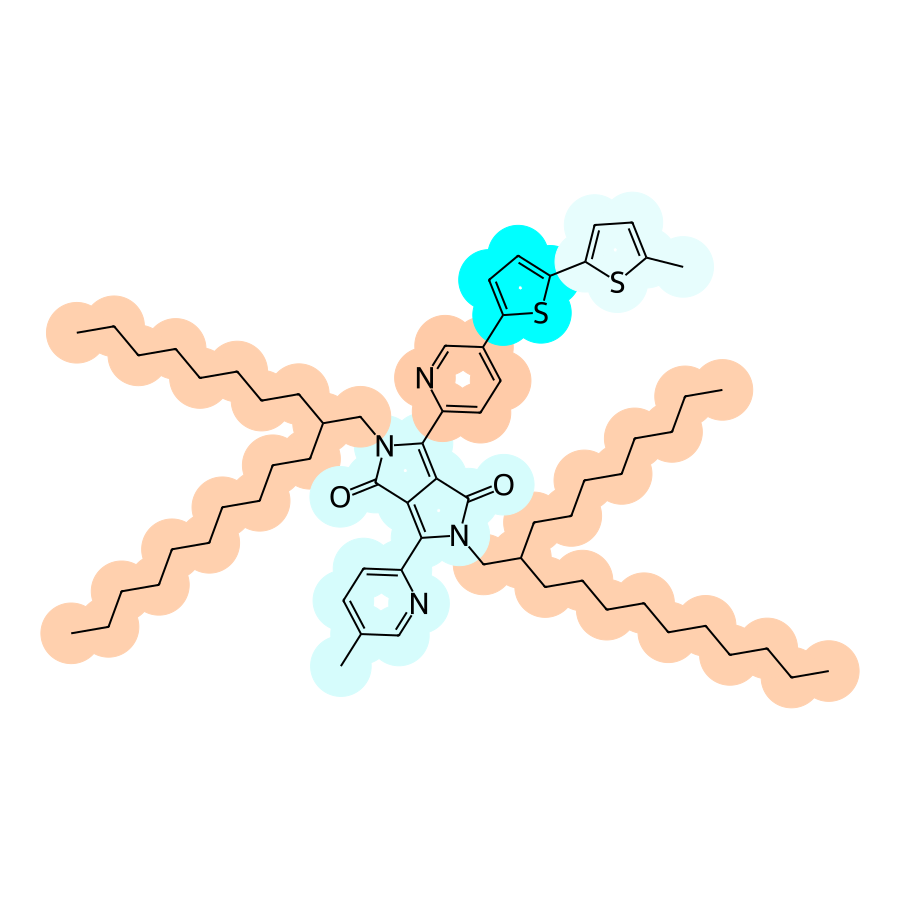

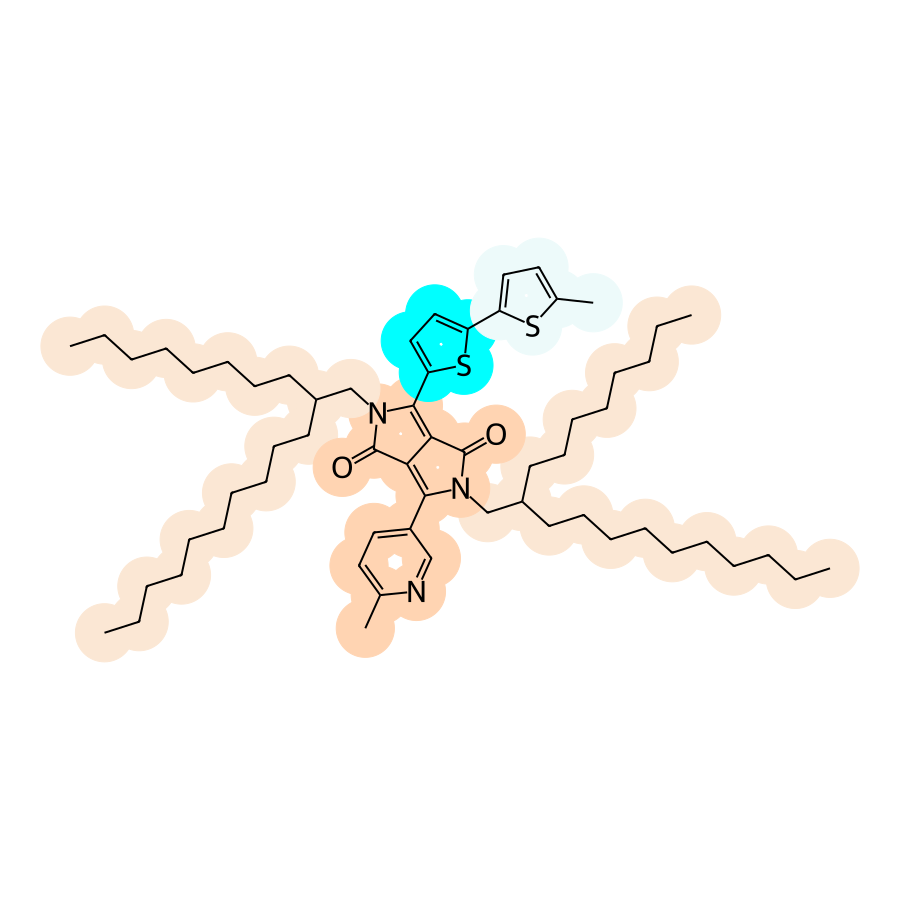

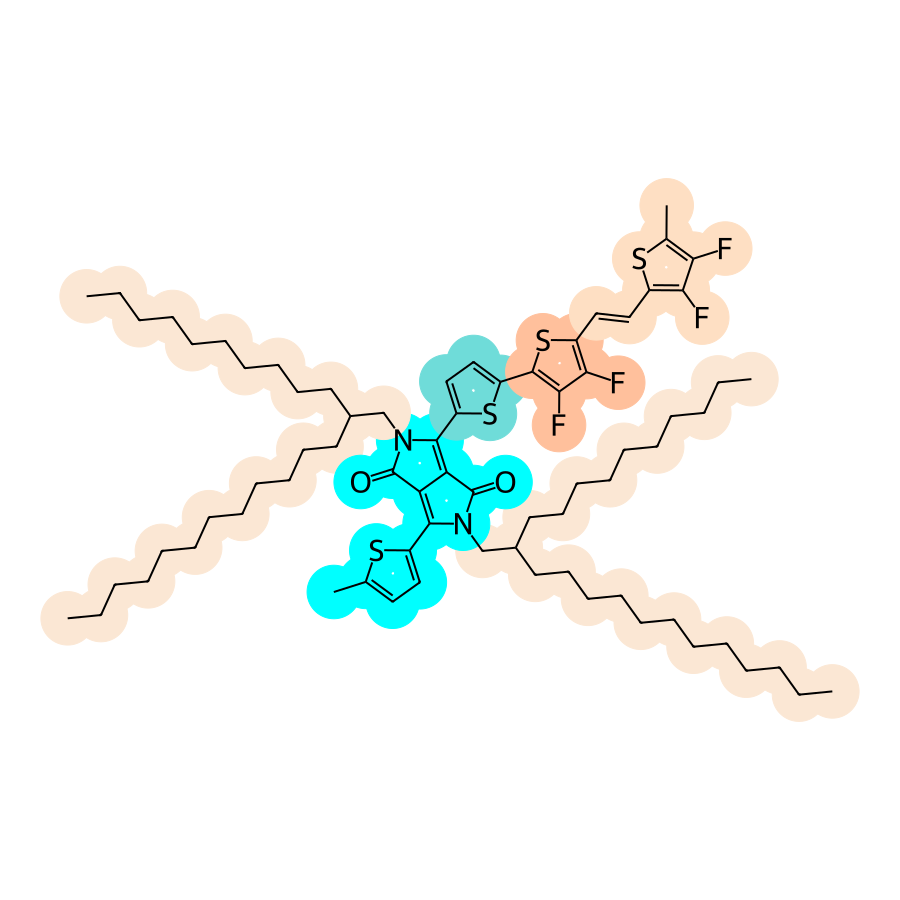

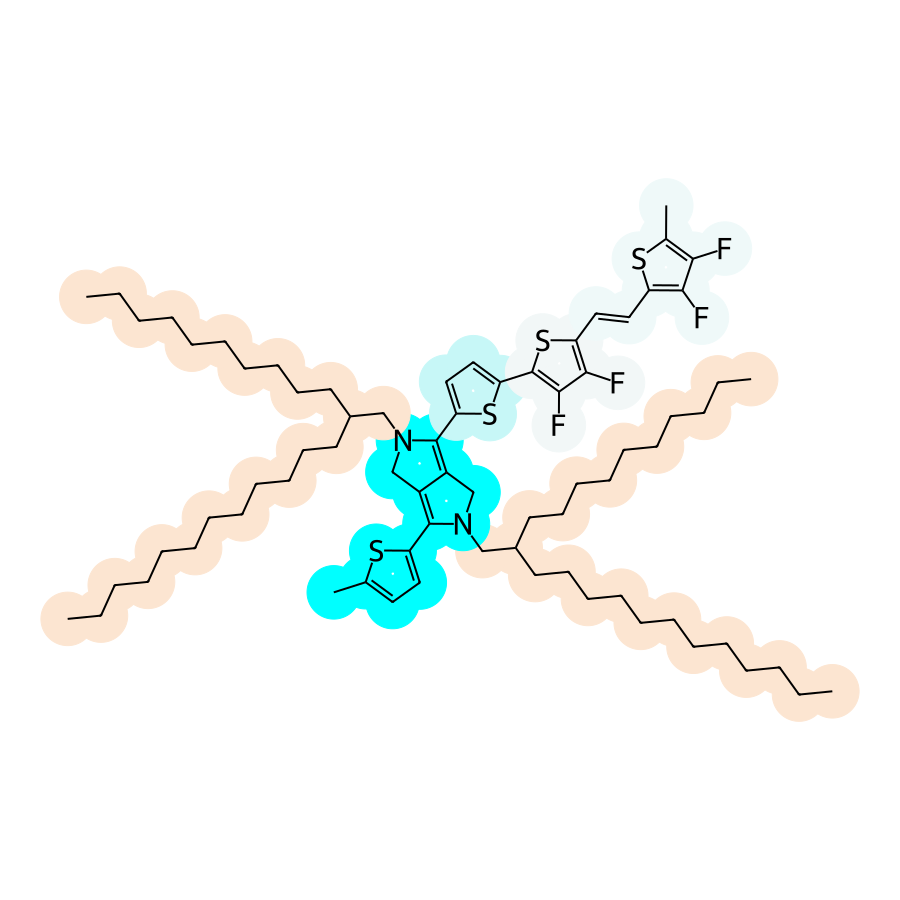

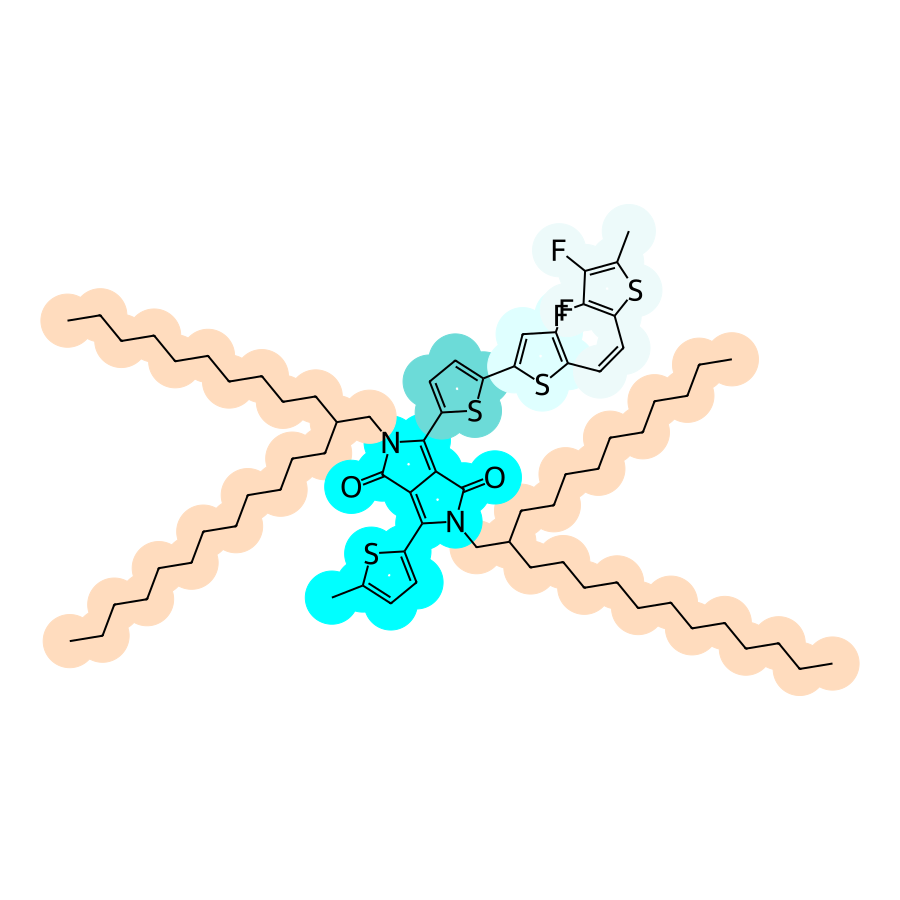

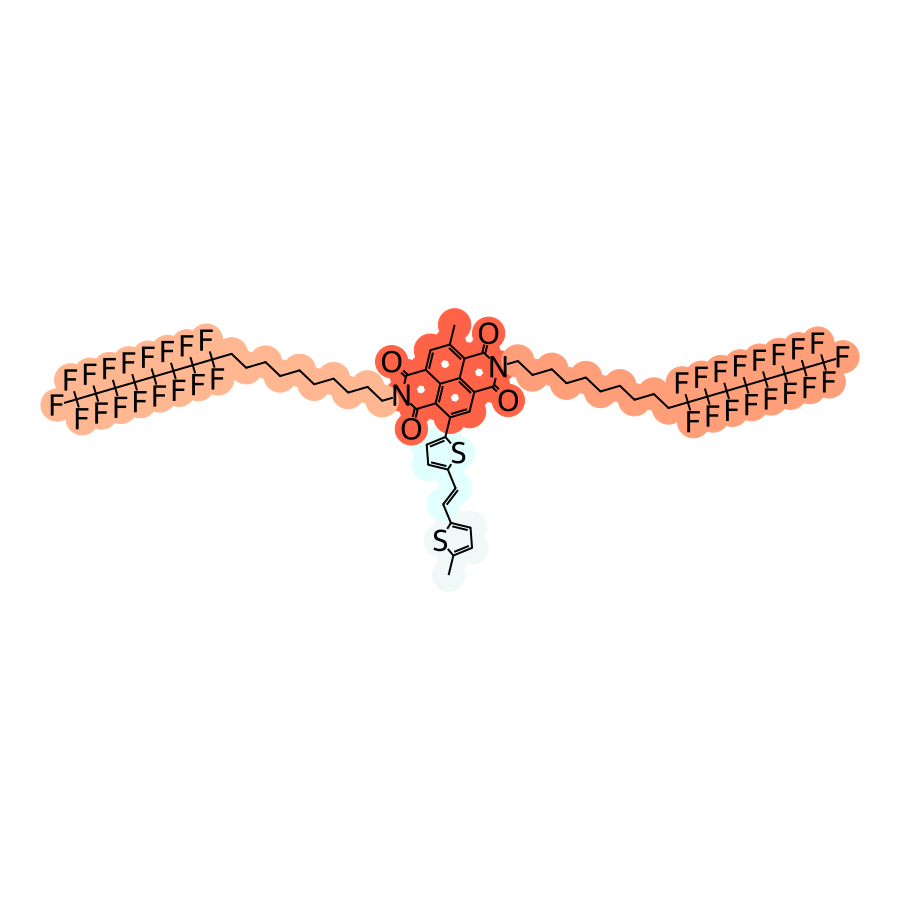

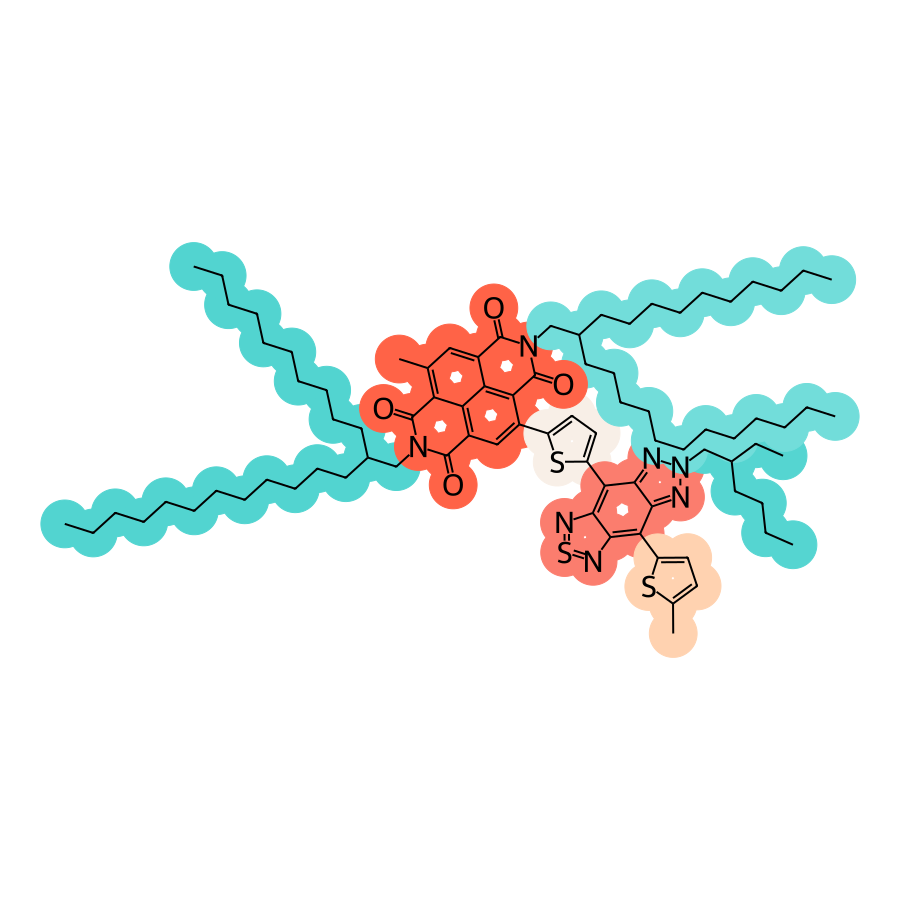

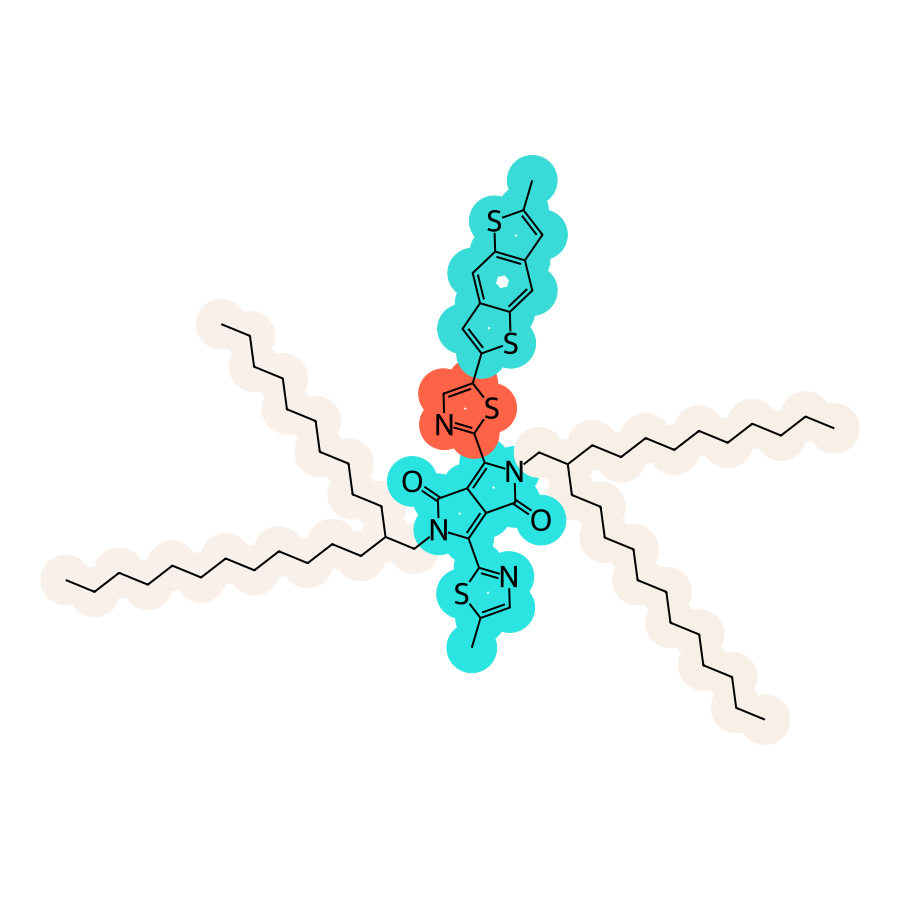

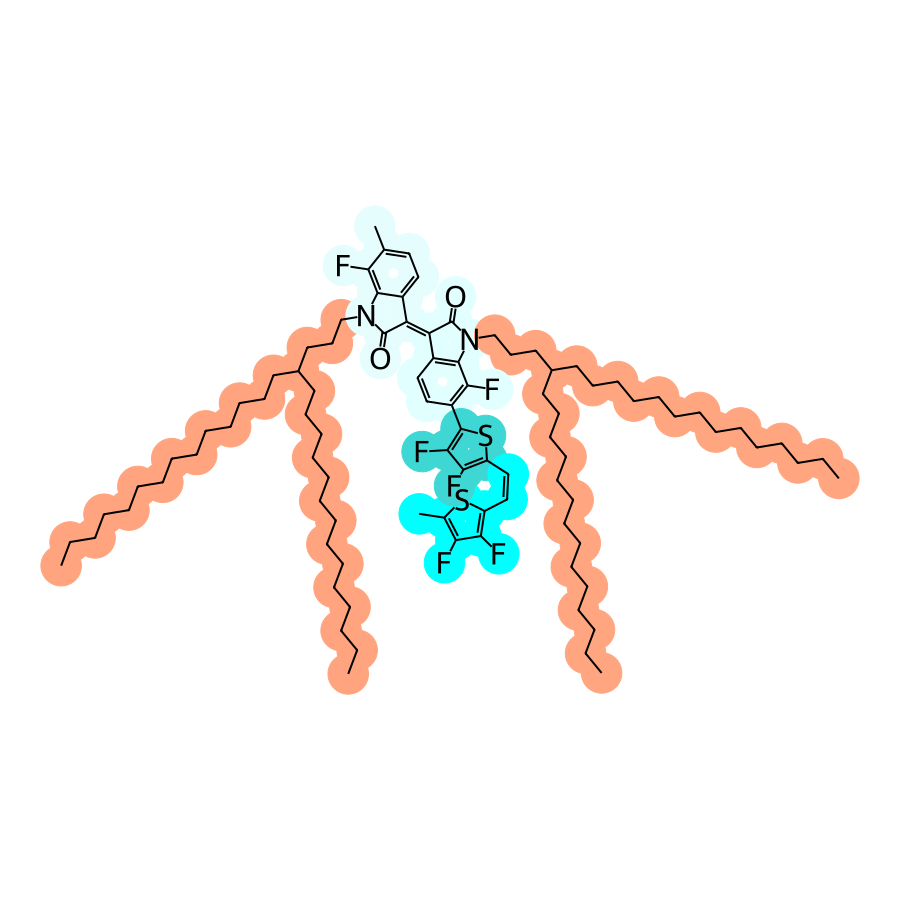

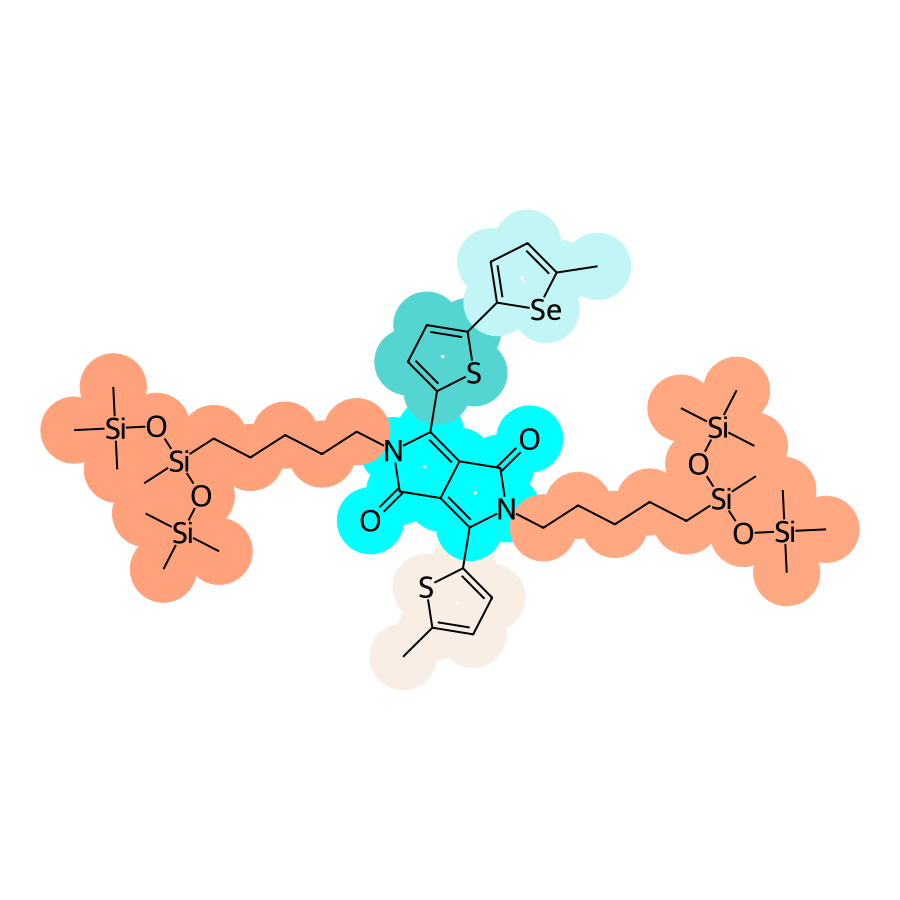

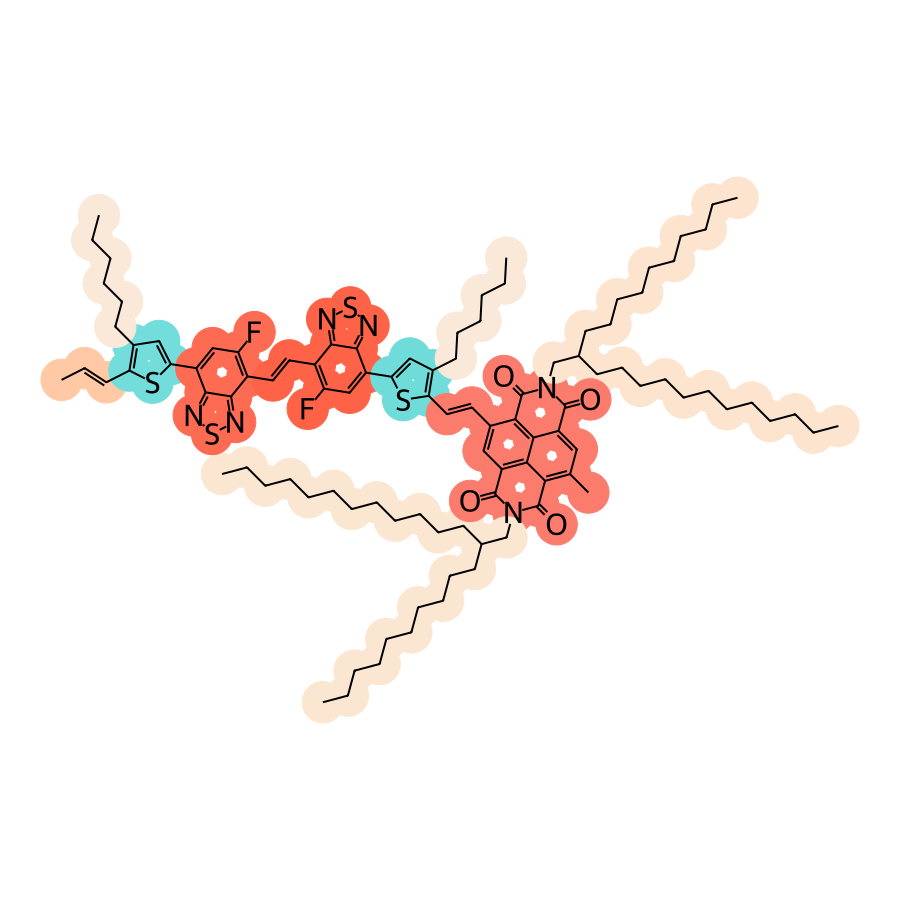

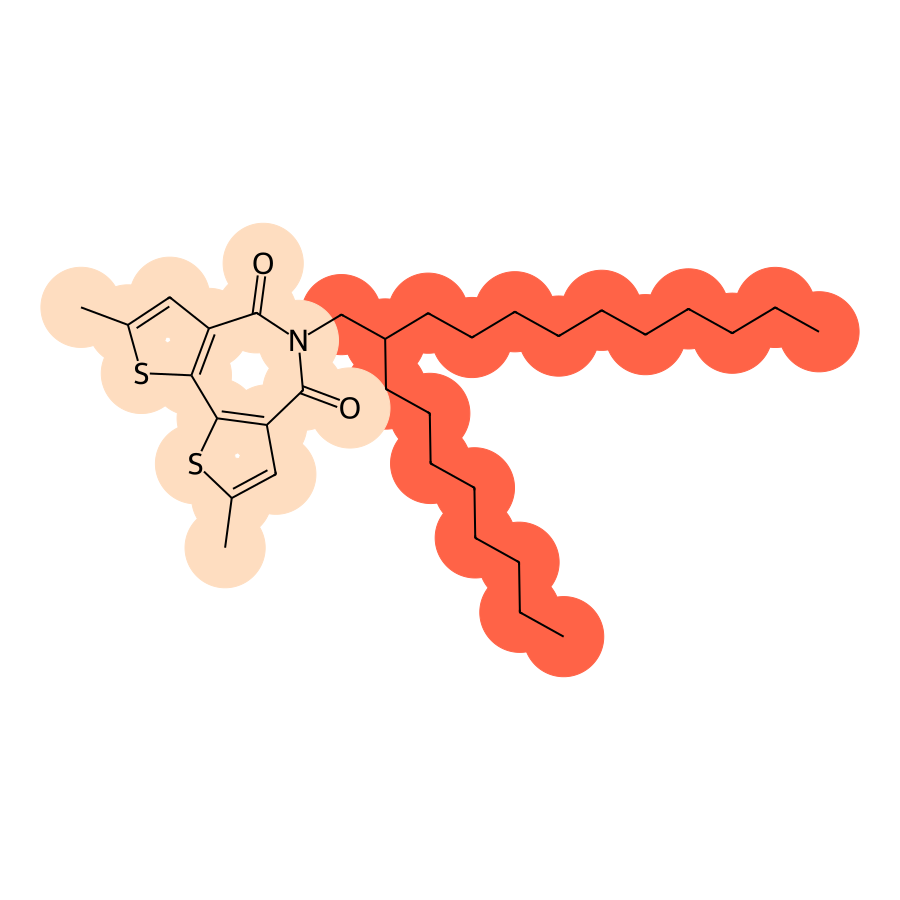

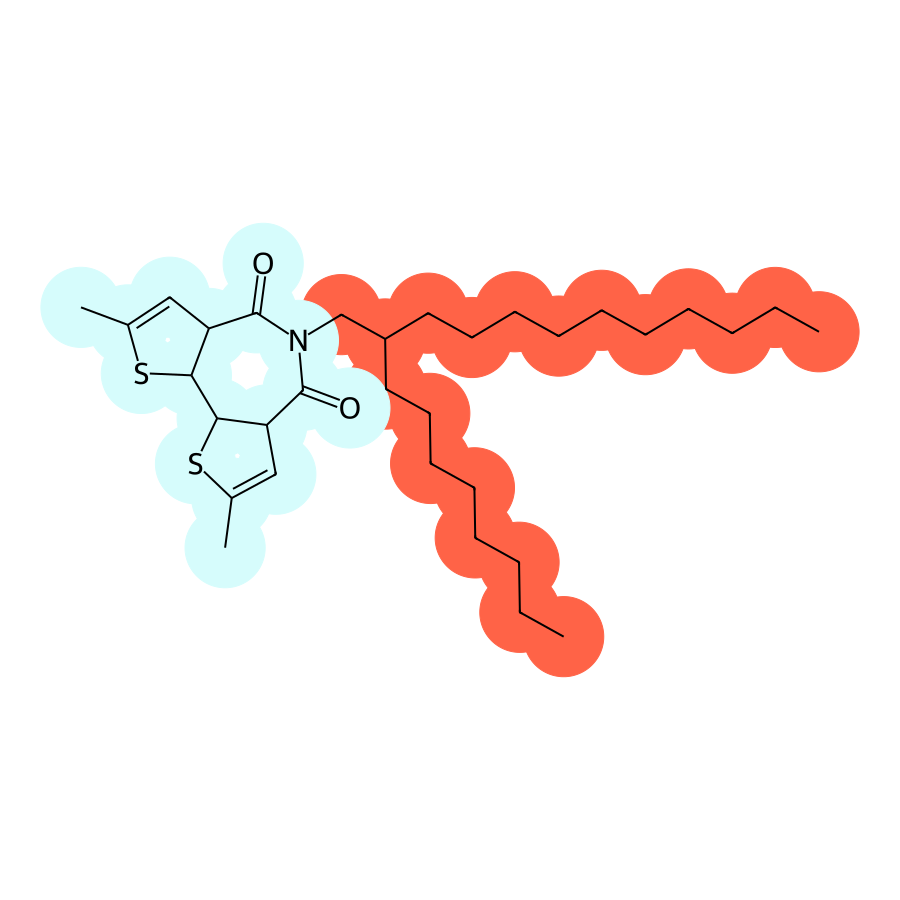

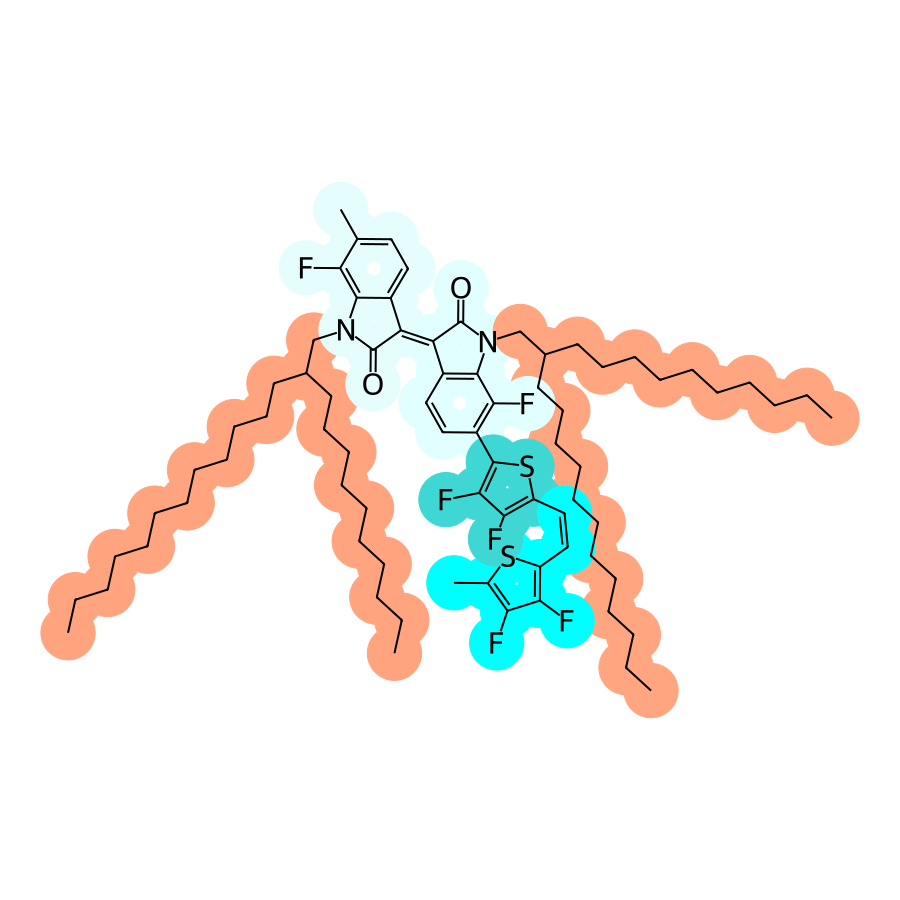

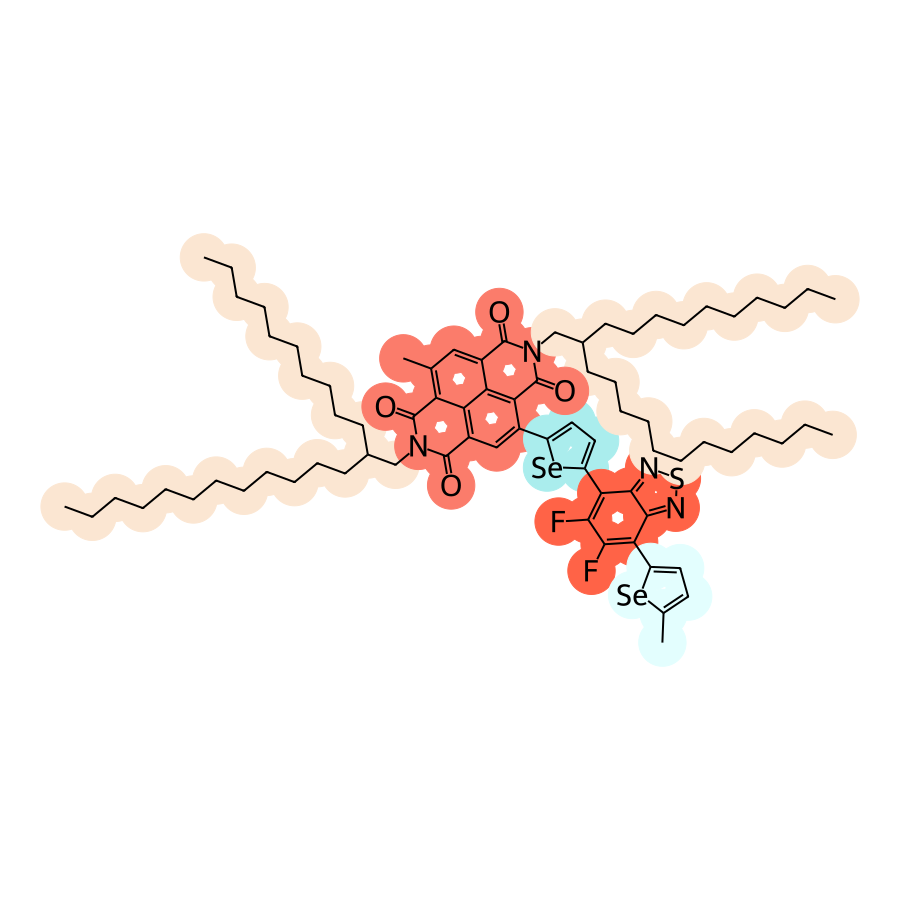

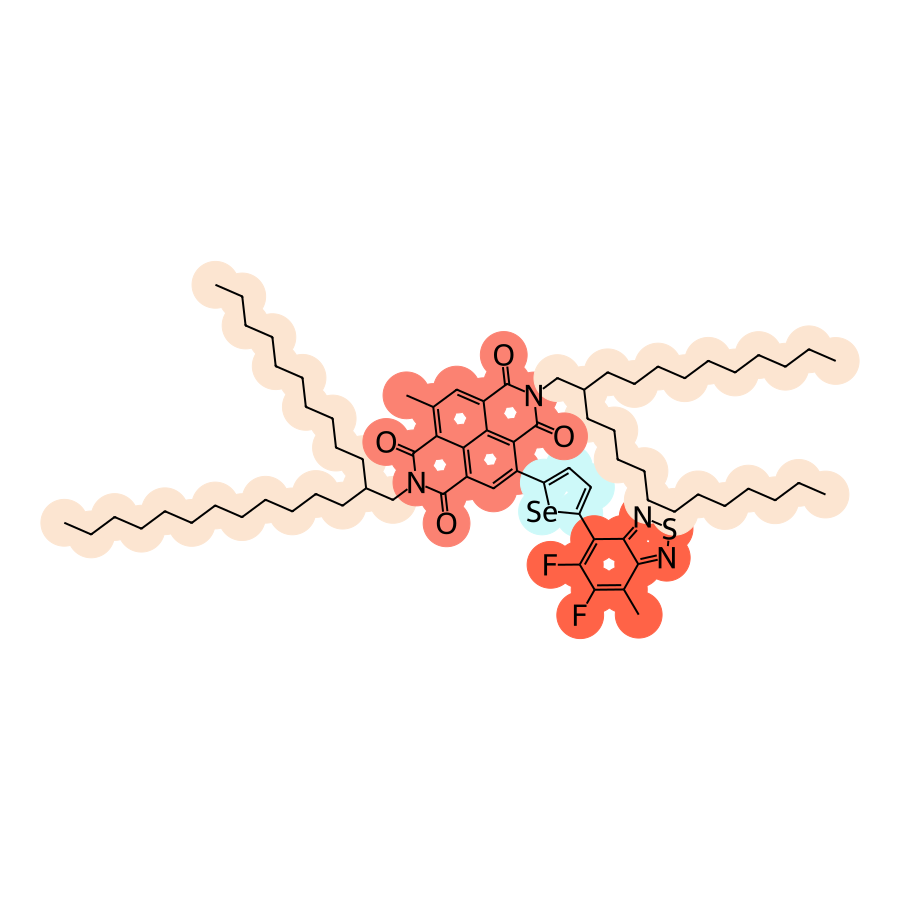

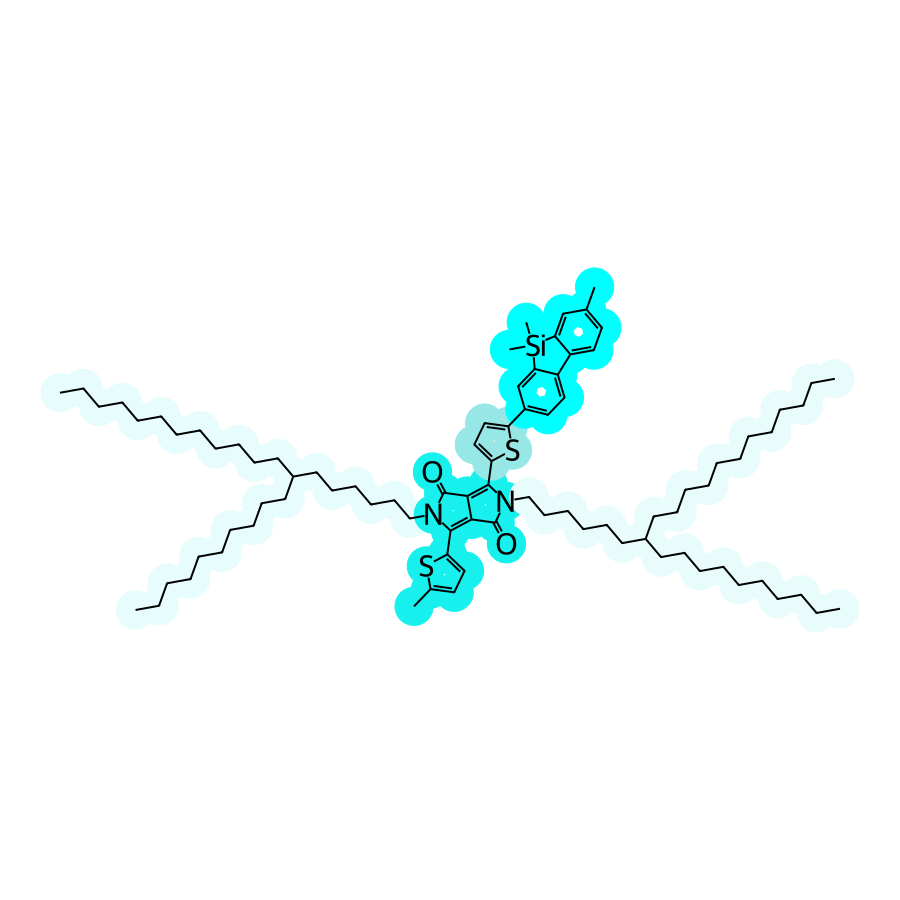

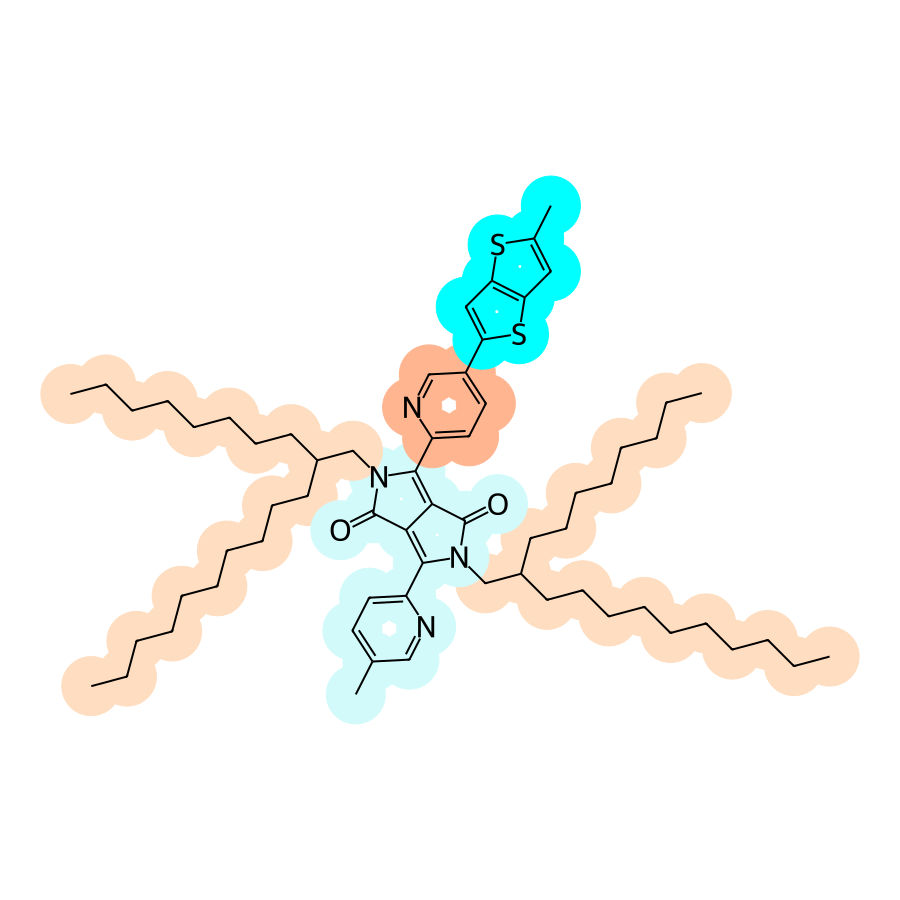

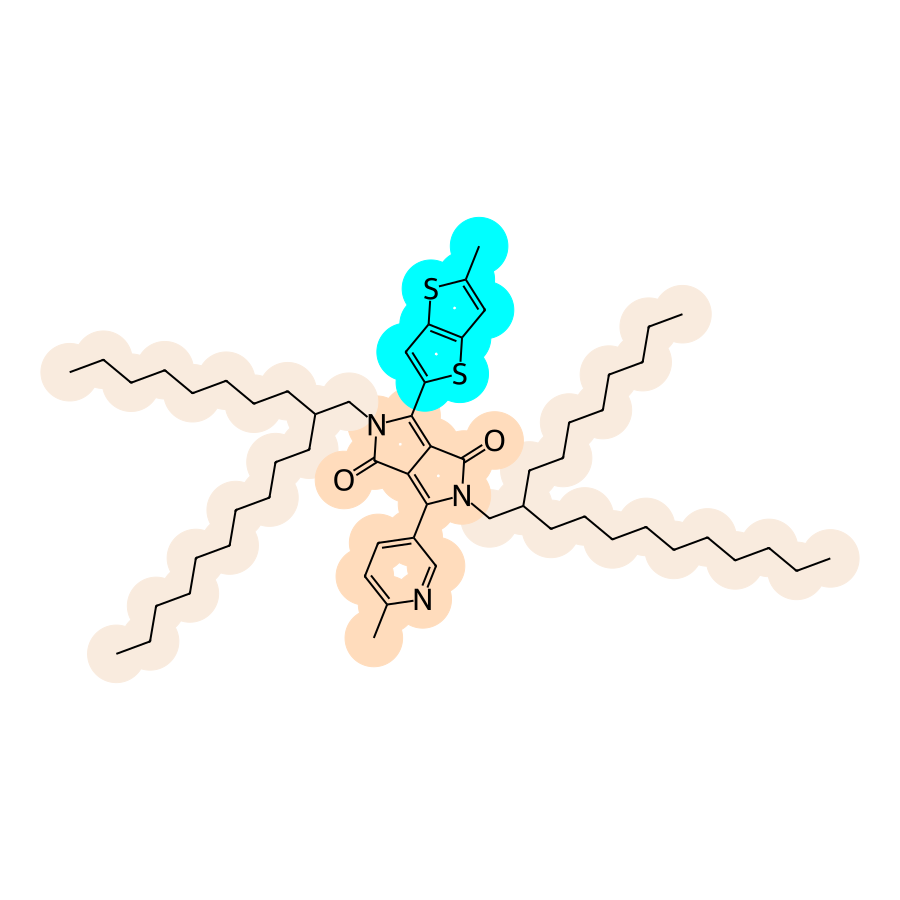

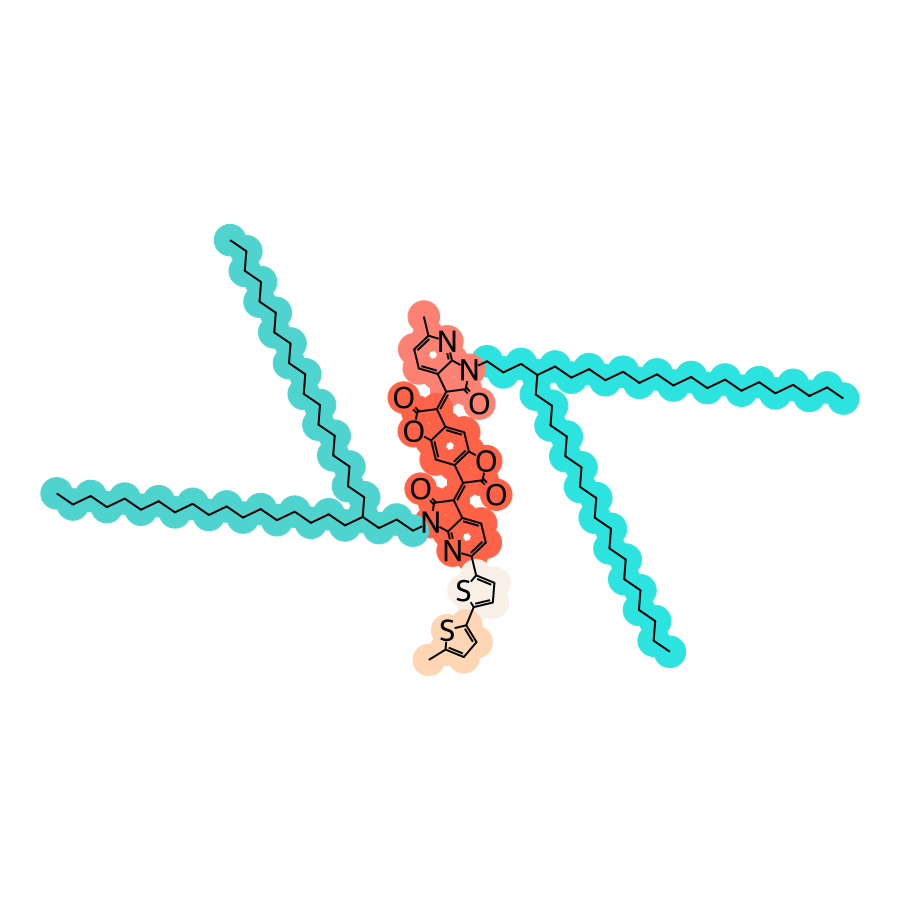

In [34]:
path = picture_path
for root,dirs,files in os.walk(path):#遍历路径中的路径，子目录，文件
    for name in files:#对于路径中的文件名
        if name.endswith('.csv'):#如果文件名以gjf结尾
            filename=path+name#定义路径+文件名
            ser = name.split('.')[0]
            path_ = path+ser+'/'
            os.makedirs(path_)
            get_analysis_picture(path_,filename,ser)

In [103]:
def get_statistics_pu(filename):
    #统计每种PU的相关性得分
    smi_list,name_list0,name_list,mol_list,num_list,label_list1,label_list2= process_smiles(filename)
    name_list2 = []
    for idx,i in enumerate(name_list):
        uh = label_list1[idx]
        ue = label_list2[idx]
        name = 'name_'+ str(i)+'_'+'uh_'+str(uh)+'_'+'ue_'+str(ue)
        name_list2.append(name)
    total_bratch_dist = get_bratch_dist2(smi_list,name_list)
    ring_total_list0,total_neighbor_data0,total_inner_dist0,_=get_pu(smi_list,name_list)
    total_neighbor_data,total_inner_dist,ring_total_list = update_bratch(name_list,smi_list,total_neighbor_data0,total_inner_dist0,total_bratch_dist)
    statistics_pu = []#记录每个pu的类型
    statistics_rel = []#记录每个pu的rel
    
    inner_dist={}
    for key,values in total_inner_dist.items():
        inner_list = []
        for k,v in values.items():
            inner_list.append(v)
        inner_dist[key]=inner_list
    pu_dist = get_pu_dist(filename)
    
    pu_dict = get_pu_dict(total_neighbor_data,ring_total_list)
    for idx,sm in enumerate(smi_list):    

        name = name_list[idx]
        solubility_target = np.nan
        mol = Chem.MolFromSmiles(sm)
        graph_in = smiles_to_graph(pu_dist,name)
        batch = tg.GraphBatch.from_graphs([graph_in]).requires_grad_().zero_grad_()
        out = net_rel(batch).global_features
        #display(Markdown(f'### {name}'))
        #display(Markdown(f'{np.round(solubility_target, 2)}\t{round(out.item(), 2)}'))
        out.backward(out)
        node_rel = batch.node_features.grad.sum(dim=1)
        pu_index = list(pu_dict[name].values())
        statistics_pu = statistics_pu + pu_index
        statistics_rel = statistics_rel + node_rel.tolist()

    return statistics_pu,statistics_rel,ring_total_list
        

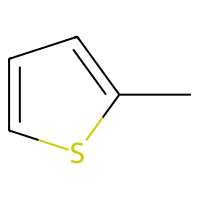

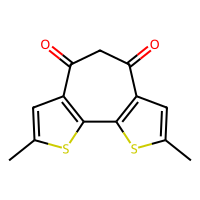

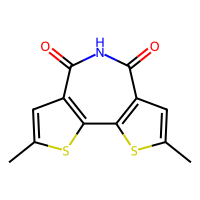

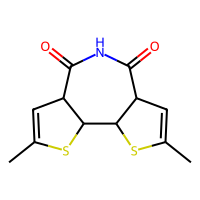

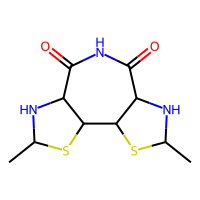

In [105]:
#显示平均相关性最高的5个结构
pu_rel = [0 for i in range(len(ring_total_list))]
pu_num = [0 for i in range(len(ring_total_list))]
for idx,i in enumerate(statistics_pu):
    pu_rel[i] = pu_rel[i]+statistics_rel[idx]
    pu_num[i] = pu_num[i] + 1
    
pu_rel_mean = (np.array(pu_rel)/np.array(pu_num)).tolist()
index = pu_rel_mean.copy()
pu_rel_mean.sort()
top = pu_rel_mean[-5:][::-1]
last = pu_rel_mean[:5]
top_index=[]
last_index=[]
top_smiles=[]
last_smiles=[]
for i in top:
    num = index.index(i)
    top_index.append(num)
    top_smiles.append(ring_total_list[num])
for i in last:
    num = index.index(i)
    last_index.append(num)
    last_smiles.append(ring_total_list[num])
#显示结构图像    
for i in top_smiles:
    mol = Chem.MolFromSmiles(i)
    fig = Draw.MolToImage(mol, size=(200,200), kekulize=True)
    display(fig)

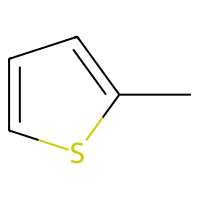

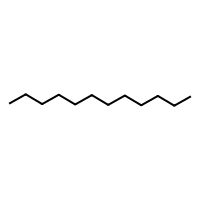

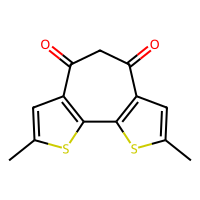

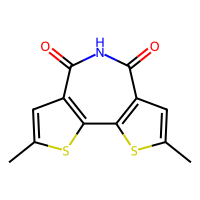

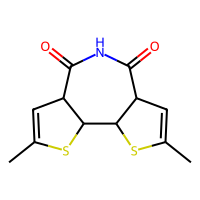

In [108]:
#显示统计相关性最高的五个结构
pu_rel = [0 for i in range(len(ring_total_list))]
pu_num = [0 for i in range(len(ring_total_list))]
for idx,i in enumerate(statistics_pu):
    pu_rel[i] = pu_rel[i]+statistics_rel[idx]
    pu_num[i] = pu_num[i] + 1
    
index = pu_rel.copy()
pu_rel.sort()
top = pu_rel[-5:][::-1]
last = pu_rel[:5]
top_index=[]
last_index=[]
top_smiles=[]
last_smiles=[]
for i in top:
    num = index.index(i)
    top_index.append(num)
    top_smiles.append(ring_total_list[num])
for i in last:
    num = index.index(i)
    last_index.append(num)
    last_smiles.append(ring_total_list[num])
    
#收集统计相关性前五名所代表的基元
statistics_point =  [[] for i in range(len(top_index))]
for idx,i in enumerate(statistics_point):
    index = top_index[idx]
    for jdx,j in enumerate(statistics_pu):
        if j == index:
            statistics_point[idx].append(statistics_rel[jdx])

#显示结构图像    
for i in top_smiles:
    mol = Chem.MolFromSmiles(i)
    fig = Draw.MolToImage(mol, size=(200,200), kekulize=True)
    display(fig)